In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 200
# plt.style.use('dark_background')

In [3]:
df = pd.read_json( 'problems MoonBoard 2016 .json' )
l = []
for i, row in df.iterrows():
    l.append( row['data'] )
df = pd.DataFrame( l )

In [4]:
# Cleaning:
df = df[df['repeats'] >= 5 ]

In [5]:
grades = {
    '': -1,
    '6B': 0,
    '6B+': 1,
    '6C': 2,
    '6C+': 3,
    '7A': 4,
    '7A+': 5,
    '7B': 6,
    '7B+': 7,
    '7C': 8,
    '7C+': 9,
    '8A': 10,
    '8A+': 11,
    '8B': 12,
    '8B+': 13
}

In [6]:
df.fillna( '', inplace = True )

In [7]:
df['grade_index'] = df.apply(
    lambda x: grades[x['grade']], axis = 1
)

In [8]:
df['userGrade_index'] = df.apply(
    lambda x: grades[x['userGrade']], axis = 1
)

Text(936.0317460317461, 0.5, 'Voted Grade')

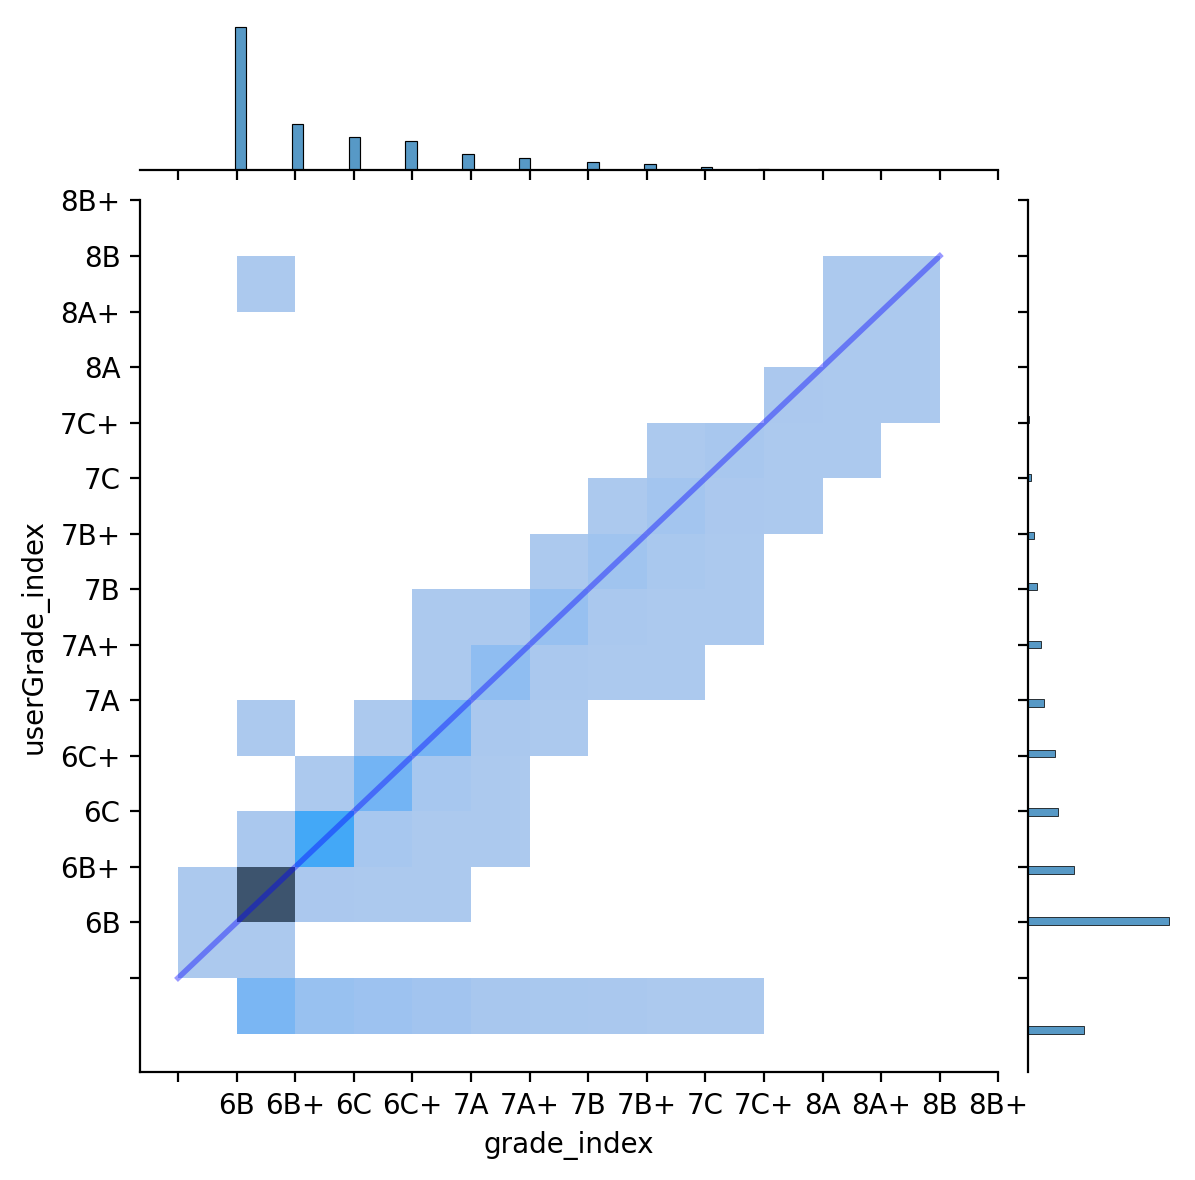

In [9]:
plot = sns.jointplot(
    data = df,
    x = 'grade_index',
    y = 'userGrade_index',
    kind = 'hist',
    binwidth = 1,
    # cmap = 'viridis'
)
plot.ax_joint.plot([0,13], [0, 13], 'b-', linewidth = 2, alpha = 0.4 )
plot.ax_joint.set_xticks( range( len( grades ) ), grades )
plot.ax_joint.set_yticks( range( len( grades ) ), grades )

plt.xlabel( 'Setter Grade' )
plt.ylabel( 'Voted Grade' )

In [10]:
grade, is_benchmark, moves, repeats = [], [], [], []
for i, row in df.iterrows():
    # row = row['data']
    grade.append(row['grade'])
    is_benchmark.append(row['isBenchmark'])
    moves.append( [ move['description'] for move in row['moves'] ] )
    repeats.append( row['repeats'] )

In [11]:
processed_df = pd.DataFrame( {
    'grade': grade,
    'is_benchmark': is_benchmark,
    'moves': moves,
    'repeats': repeats
} )

In [12]:
display( processed_df )

,grade,is_benchmark,moves,repeats
0,6B+,True,"[E6, C5, E8, F11, C13, D15, D18]",28038
1,6B+,True,"[F5, J8, I11, K11, G13, E15, E18]",40377
2,6B+,False,"[F5, J5, F9, C10, G13, E15, I18]",863
3,7A,True,"[B10, E6, E8, E12, E16, G4, I18, J5]",9514
4,7A,False,"[C5, D7, A9, F11, F13, I14, E16, D18]",275
...,...,...,...,...
28563,6C+,False,"[F5, J2, C6, H10, K8, G13, I14, K12, E15, G18,...",5
28564,6B+,False,"[G6, I6, H8, G4, E10, G13, E15, E18]",5
28565,6B+,False,"[F5, E10, H8, G13, H16, E16, D18]",11
28566,6B+,False,"[F5, G2, G9, C10, E12, A14, E16, B18]",5


In [13]:
holds = []

for i in range( 1, 150 ):
    try:
        hold = Image.open( 'holds/h' + str( i ) + '.png' )
        hold.load()
        holds.append( {
            'hold': hold,
            'i': i
        } )
    except:
        continue

In [14]:
import json

f = open( '2016holdset.txt' )
data = json.loads( f.read() )

locations = []

for holdset in data:
    for location in holdset['Holds']:
        locations.append( location['Location'] )

In [15]:
for location in locations:
    i = int( location['HoldNumber'] )
    
    for hold in holds:
        if hold['i'] == i:
            # print( 'Rotating hold', i, 'by', location['Rotation'] )
            hold['hold'] = hold['hold'].rotate( 360 - location['Rotation'] )

In [16]:
print( locations[0] )

{'Id': 0, 'Holdset': None, 'Description': 'H7', 'X': 445, 'Y': 636, 'Color': None, 'Rotation': 135, 'Type': 0, 'HoldNumber': '1', 'Direction': 2, 'DirectionString': 'SE'}


In [17]:
def moves_to_image( moves, holds, locations, plot = False ):
    # Plot all the holds on the board in the correct position
    img = Image.new( mode = "RGBA", size = ( 700, 1000 ) )

    for move in moves:
        for location in locations:
            if move != location['Description']:
                continue
            
            i = int( location['HoldNumber'] )

            for hold in holds:
                if hold['i'] == i:
                    top_left = ( int( location['X'] - hold['hold']._size[0] / 2 ), int( location['Y'] - hold['hold']._size[1] / 2 ) )
                    img.paste( hold['hold'], top_left, hold['hold'] )
                    break
    if plot:
        plt.imshow( img )
    return np.array( img )

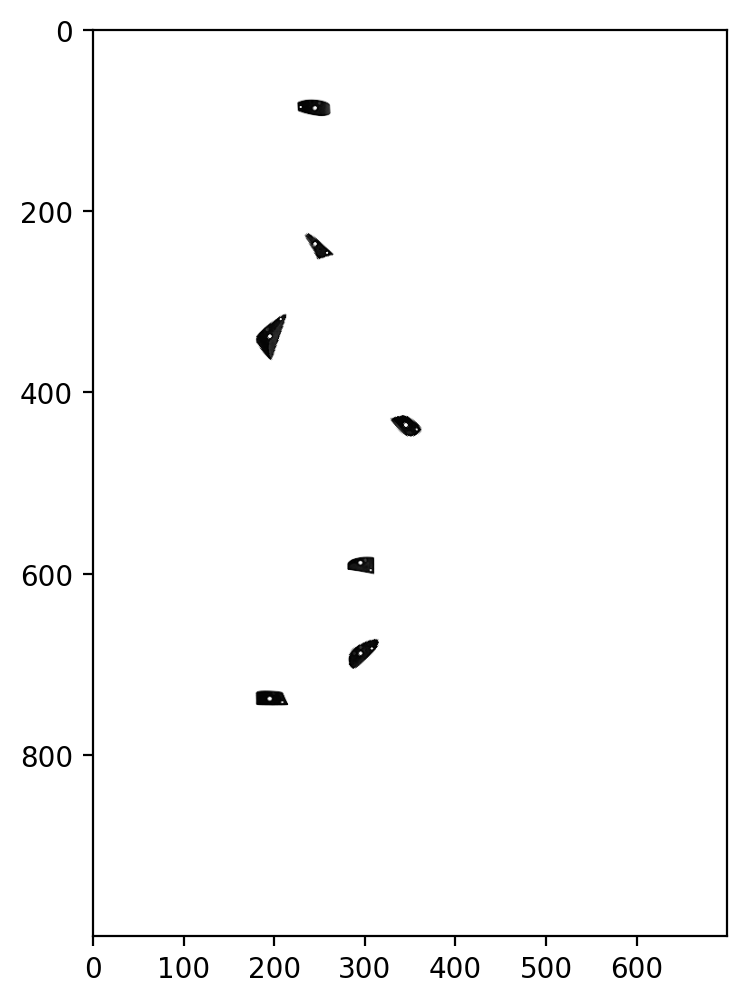

In [19]:
img = moves_to_image( processed_df['moves'].iloc[0], holds, locations, plot = True )

In [19]:
def moves_to_features( moves ):
    features = np.zeros( ( 18, 11 ) )
        
    for move in moves:
        features[int( move[1:] ) - 1, ord( str( move[0] ).upper() ) - 65 ] = 1
    # return np.flip( np.flip( features, axis = 0 ), axis = 1 )
    return np.flip( features, axis = 0 )

In [20]:
import swifter

In [21]:
processed_df['features'] = processed_df.swifter.apply( 
    lambda x: moves_to_image( x['moves'], holds, locations, plot = False ), axis = 1
)

Pandas Apply:   0%|          | 0/28568 [00:00<?, ?it/s]

In [22]:
processed_df['grade_index'] = processed_df.apply(
    lambda x: grades[x['grade']], axis = 1
)

In [23]:
processed_df['n_holds'] = processed_df.apply(
    lambda x: len( x['moves'] ), axis = 1
)

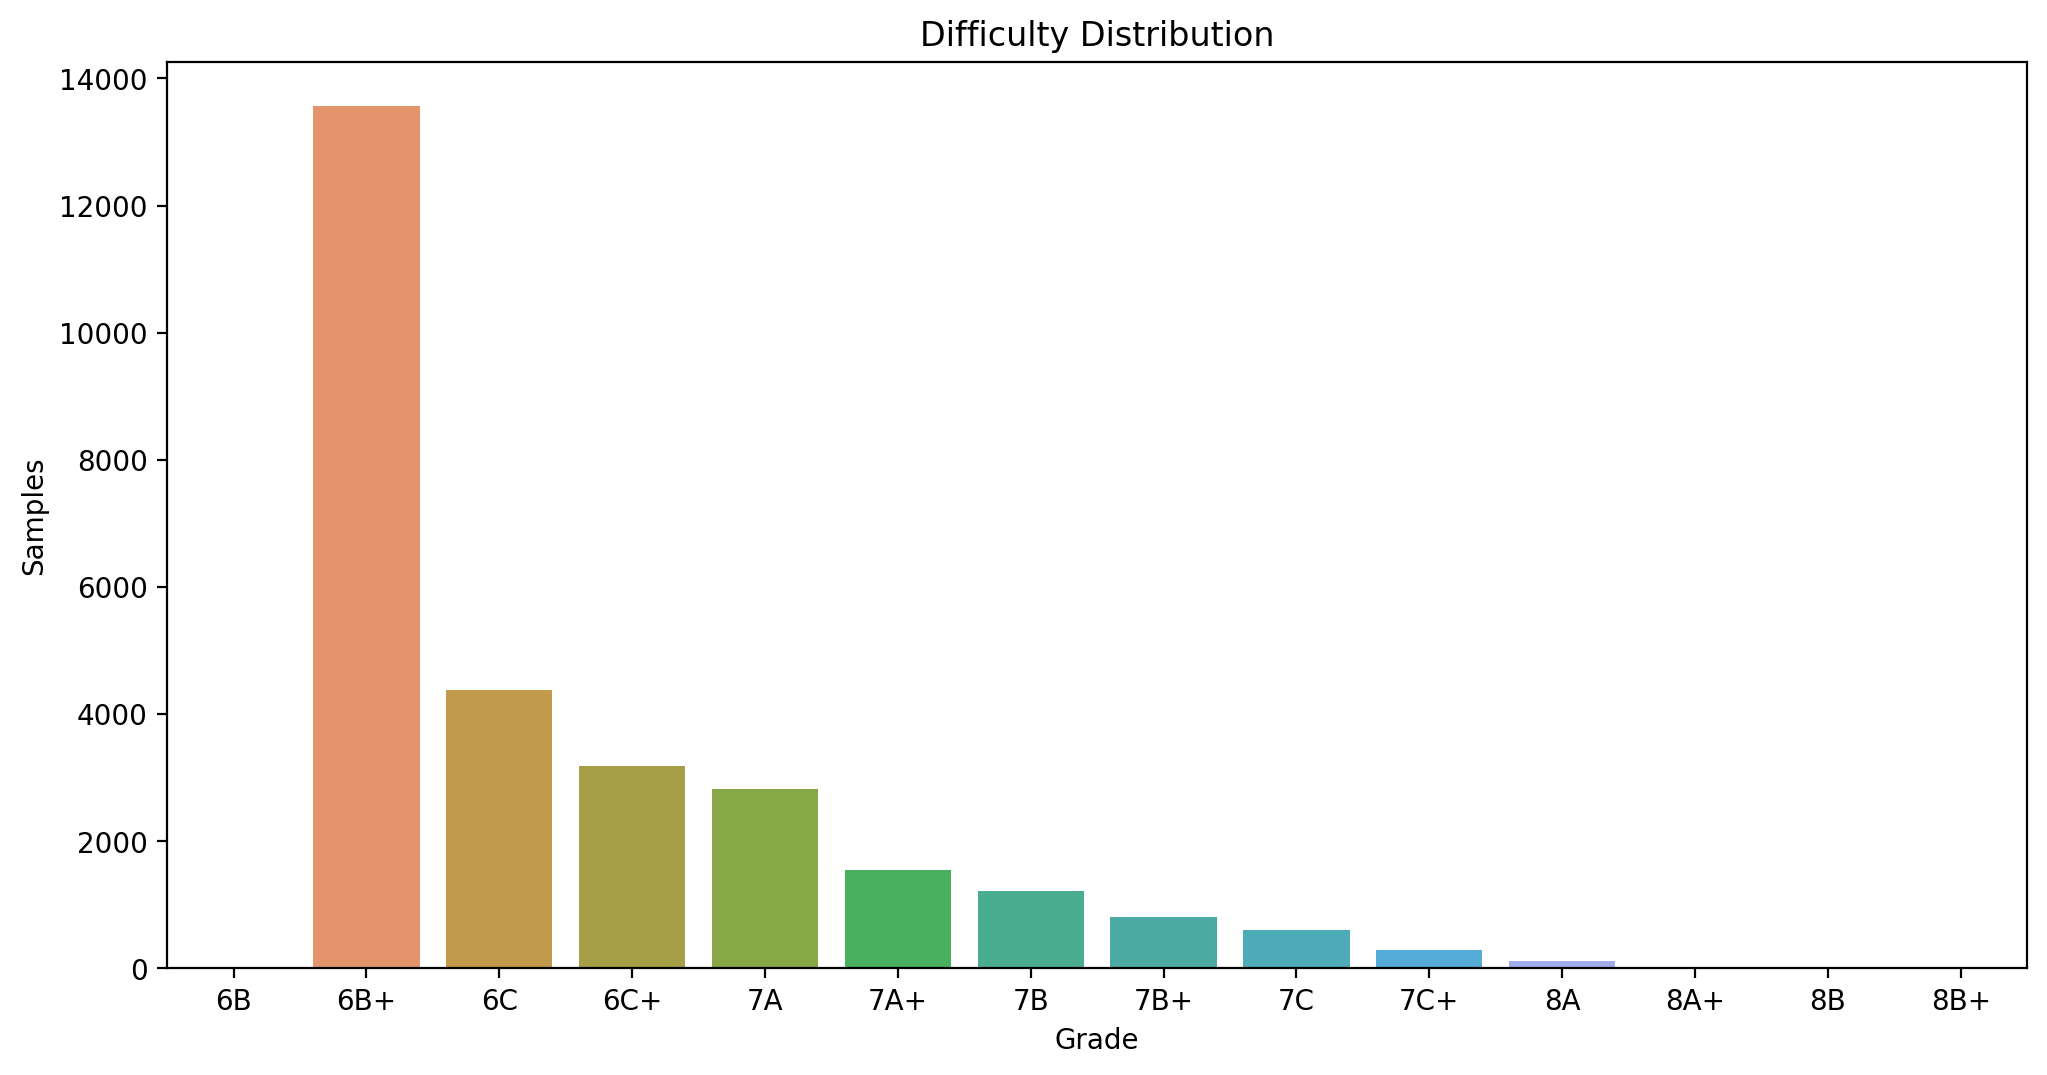

In [24]:
p = sns.countplot(
    data = processed_df,
    x = 'grade',
    order = np.sort( processed_df['grade'].unique() ),
)
p.set( title = 'Difficulty Distribution' )
p.set( ylabel = 'Samples' )
p.set( xlabel = 'Grade' )
plt.show()

In [25]:
display( processed_df )

,grade,is_benchmark,moves,repeats,features,grade_index,n_holds
0,6B+,True,"[E6, C5, E8, F11, C13, D15, D18]",28038,"[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...",1,7
1,6B+,True,"[F5, J8, I11, K11, G13, E15, E18]",40377,"[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...",1,7
2,6B+,False,"[F5, J5, F9, C10, G13, E15, I18]",863,"[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...",1,7
3,7A,True,"[B10, E6, E8, E12, E16, G4, I18, J5]",9514,"[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...",4,8
4,7A,False,"[C5, D7, A9, F11, F13, I14, E16, D18]",275,"[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...",4,8
...,...,...,...,...,...,...,...
28563,6C+,False,"[F5, J2, C6, H10, K8, G13, I14, K12, E15, G18,...",5,"[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...",3,11
28564,6B+,False,"[G6, I6, H8, G4, E10, G13, E15, E18]",5,"[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...",1,8
28565,6B+,False,"[F5, E10, H8, G13, H16, E16, D18]",11,"[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...",1,7
28566,6B+,False,"[F5, G2, G9, C10, E12, A14, E16, B18]",5,"[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...",1,8


In [26]:
from keras.models import Sequential
from keras import layers
import tensorflow as tf

2023-09-20 13:51:26.624415: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-20 13:51:27.215121: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-20 13:51:37.455469: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64
2023-09-20 13:51:37.455569: W tensorflow/compiler/xla/stream

In [27]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

def evaluate( train_predictions, predictions, y_train, y_test, plot_predictions = False ):
    metrics = {
        'train_mae': mae( y_train, train_predictions ),
        'train_rmse': mse( y_train, train_predictions ) ** ( 1 / 2 ),
        'test_mae': mae( y_test, predictions ),
        'test_rmse': mse( y_test, predictions ) ** ( 1 / 2 ),
    }
    
    if plot_predictions == True:
            plot = sns.jointplot(
                predictions,
                y_test,
                kind = 'hist',
            )
            plot.ax_joint.set_xticks( range( len( grades ) ), grades )
            plot.ax_joint.set_yticks( range( len( grades ) ), grades )
            plot.ax_joint.plot([0,13], [0, 13], 'b-', linewidth = 2, alpha = 0.4 )
            plot.ax_joint.set_xlabel( 'Predicted Grade' )
            plot.ax_joint.set_ylabel( 'True Grade' )

            plt.show()
    
    return metrics

In [ ]:
## Check this ~~~~~

In [34]:
X_train = np.stack( np.array( processed_df[processed_df['is_benchmark'] == False]['features'] ) )
X_test = np.stack( np.array( processed_df[processed_df['is_benchmark'] == True]['features'] ) )

y_train = np.array( processed_df[processed_df['is_benchmark'] == False]['grade_index'].tolist() )
y_test = np.array( processed_df[processed_df['is_benchmark'] == True]['grade_index'].tolist() )

In [ ]:
train_repeats = np.array( processed_df[processed_df['is_benchmark'] == False]['repeats'].tolist() )

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes = np.unique( y_train ),
    y = y_train
)
class_weights = dict( enumerate( class_weights ) )

In [ ]:
print( class_weights )

In [ ]:
X = np.array( processed_df['features'].tolist() ).reshape( -1, 18 * 11 )
y = np.array( processed_df['grade_index'].tolist() )

In [35]:
import time
import datetime

In [27]:
def custom_loss_function( y_true, y_pred ):
    
    return 

In [38]:
moonnet = Sequential( [
    layers.Input( shape = ( 700, 1000, 4 ) ),
    
    layers.Resizing( 256, 180 ),
    
    # CV Model!
    layers.Conv2D( 64, 8, activation = 'relu' ),
    layers.BatchNormalization(),
    layers.Conv2D( 64, 8, activation = 'relu' ),
    layers.BatchNormalization(),
    layers.Conv2D( 64, 8, activation = 'relu' ),
    layers.BatchNormalization(),
    layers.Conv2D( 64, 8, activation = 'relu' ),
    layers.BatchNormalization(),
    layers.Conv2D( 64, 8, activation = 'relu' ),
    layers.BatchNormalization(),
    layers.Conv2D( 64, 8, activation = 'relu' ),
    layers.BatchNormalization(),
    
    
    layers.Flatten(),
    layers.Dense( 32, activation = 'relu' ),
    layers.Dense( 1, activation = 'linear' ),
] )

models = [ moonnet ]

2023-09-20 14:13:18.415154: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-20 14:13:18.573902: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-20 14:13:18.574218: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-20 14:13:18.590705: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operati

ResourceExhaustedError: {{function_node __wrapped__StatelessRandomUniformV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[1890048,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:StatelessRandomUniformV2]

In [ ]:
for model in models:
    model.compile(
        loss = 'mean_squared_error',
        optimizer = 'adam',
    )

In [86]:
model_names = [ 'MoonNet' ]

scores = []

for model, model_name in zip( models, model_names ):
    print( model_name )
    start_time = time.time()
    history = model.fit( 
        X_train, 
        y_train,
        validation_data = ( X_test, y_test ),
        sample_weight = np.log( train_repeats ) + 1,
        # class_weight = class_weights,
        epochs = 200,
        batch_size = 32,
        # verbose = 0,
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor = "val_loss",
                patience = 5,
                restore_best_weights = True,
                start_from_epoch = 25,
            )
        ]
    )
    
    for key in history.history.keys():
        plt.plot( history[key] )
    plt.show()
    
    timestamp = time.time() - start_time
    print( 'Time to Fit:', timestamp )
    
    train_predictions = model.predict( X_train )
    predictions = model.predict( X_test )
    
    scores.append( evaluate( train_predictions, predictions, y_train, y_test, plot_predictions = True ) )
    print( scores[-1] )
    print()

DNN
Epoch 1/200
876/876 [==============================] - 2s 2ms/step - loss: 2.7390 - val_loss: 1.6232
Epoch 2/200
876/876 [==============================] - 2s 2ms/step - loss: 2.3898 - val_loss: 1.6248
Epoch 3/200
876/876 [==============================] - 2s 2ms/step - loss: 2.2658 - val_loss: 1.6364
Epoch 4/200
876/876 [==============================] - 2s 2ms/step - loss: 2.1842 - val_loss: 1.6078
Epoch 5/200
876/876 [==============================] - 2s 2ms/step - loss: 2.1097 - val_loss: 1.6817
Epoch 6/200
876/876 [==============================] - 2s 2ms/step - loss: 2.0471 - val_loss: 1.7063
Epoch 7/200
876/876 [==============================] - 2s 2ms/step - loss: 1.9847 - val_loss: 1.7605
Epoch 8/200
876/876 [==============================] - 2s 2ms/step - loss: 1.9228 - val_loss: 1.7712
Epoch 9/200
876/876 [==============================] - 2s 2ms/step - loss: 1.8751 - val_loss: 1.7882
Epoch 10/200
876/876 [==============================] - 2s 2ms/step - loss: 1.8335 - va

In [47]:
scores = pd.DataFrame( scores )
scores['names'] = model_names

names = {
    'train_mae': 'Training MAE',
    'train_rmse': 'Training RMSE',
    'test_mae': 'Testing MAE',
    'test_rmse': 'Testing RMSE',
    'names': 'Model Name',
}

scores = scores.rename( columns = names )

display( scores )

,Training MAE,Training RMSE,Testing MAE,Testing RMSE,Model Name
0,0.470225,0.684661,1.077504,1.402568,DNN
1,0.422103,0.611810,0.982262,1.297632,2DCNN
2,0.726770,1.055582,0.981422,1.226925,LSTM


[]

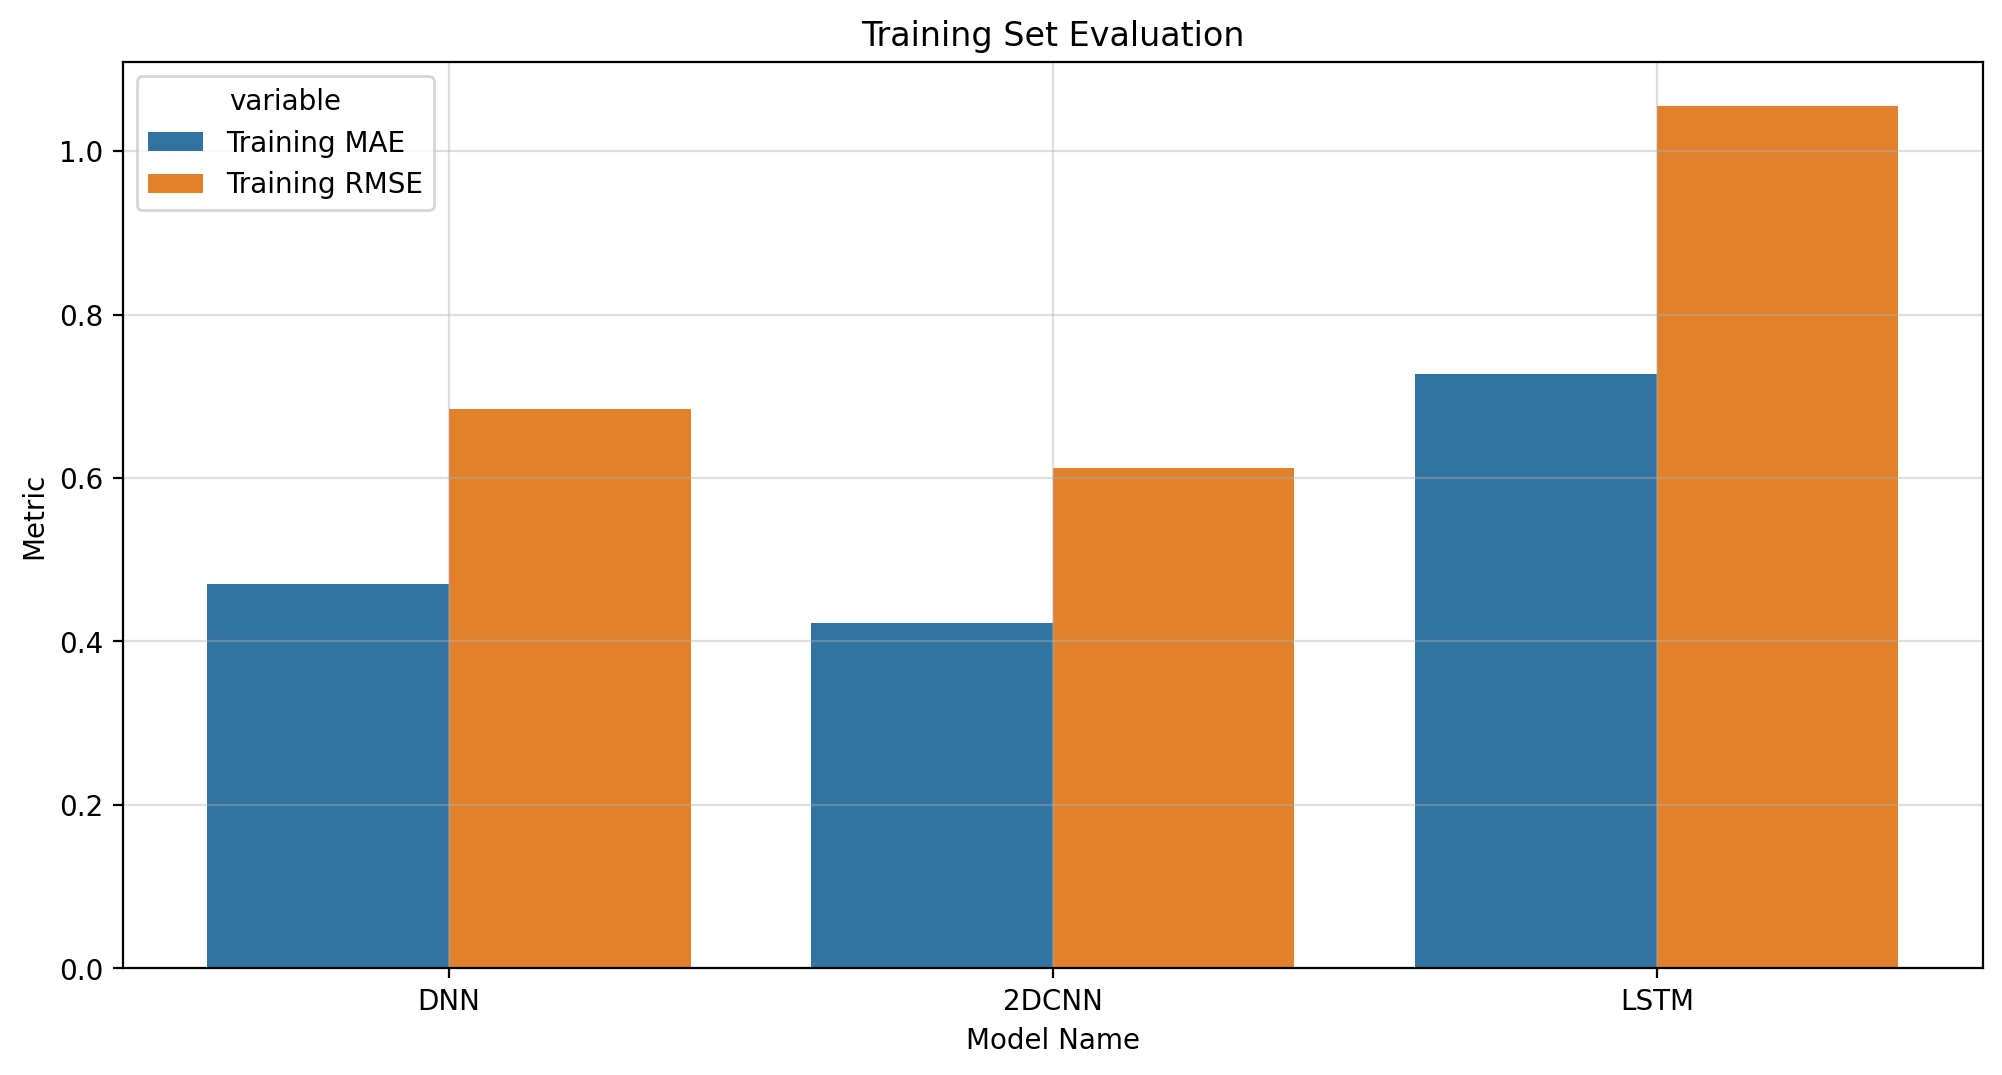

In [48]:
plot = sns.barplot(
    data = pd.melt( scores, id_vars = 'Model Name', value_vars = [ 'Training MAE', 'Training RMSE' ] ),
    y = 'value',
    x = 'Model Name',
    hue = 'variable',
    palette = 'tab10'
)
plot.set_title( 'Training Set Evaluation' )
plt.ylabel( 'Metric' )
plt.grid( alpha = 0.4 )
plt.plot()

[]

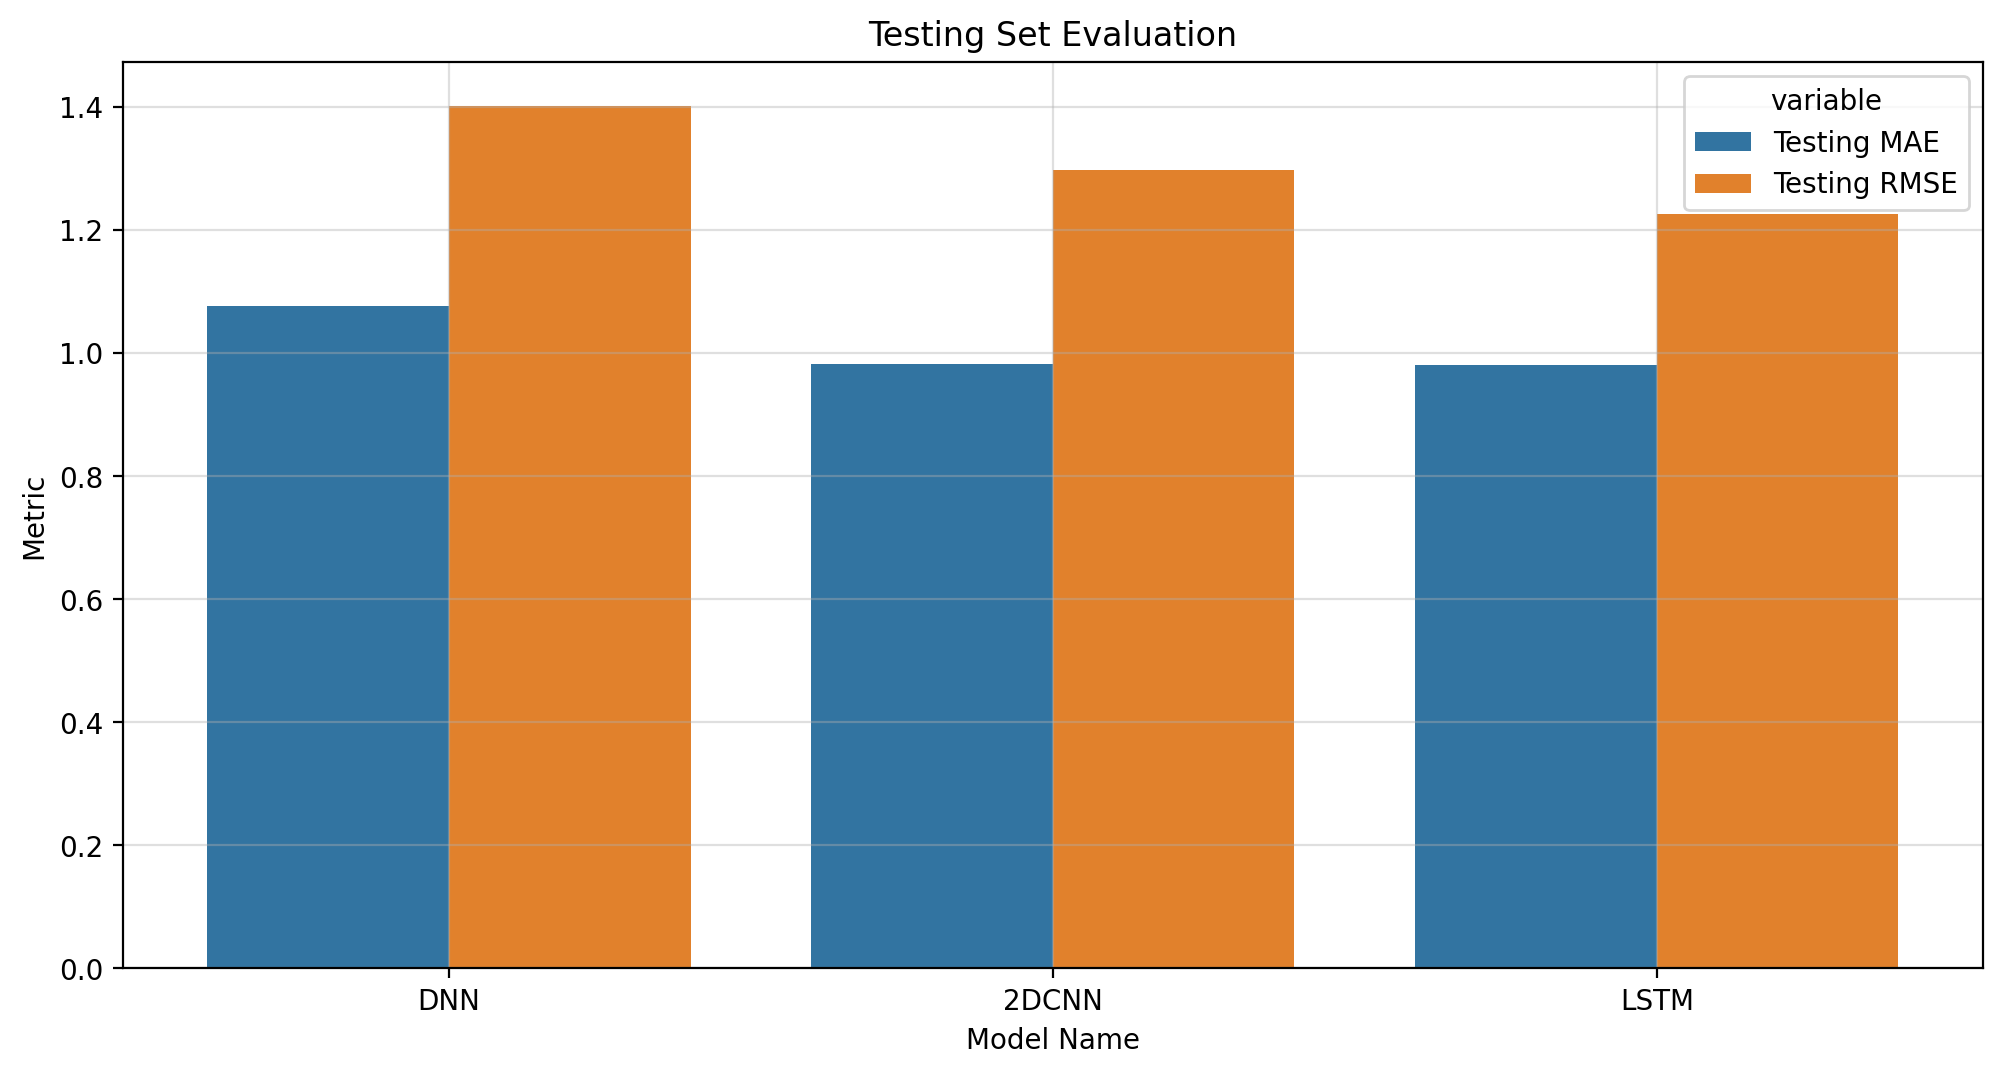

In [49]:
plot = sns.barplot(
    data = pd.melt( scores, id_vars = 'Model Name', value_vars = [ 'Testing MAE', 'Testing RMSE' ] ),
    y = 'value',
    x = 'Model Name',
    hue = 'variable',
    palette = 'tab10'
)
plot.set_title( 'Testing Set Evaluation' )
plt.ylabel( 'Metric' )
plt.grid( alpha = 0.4 )
plt.plot()

In [110]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [111]:
predictions = np.round( predictions )

print( classification_report( y_test, predictions, labels = range( 14 ), target_names = [ key for key in grades.keys() ][1:] ) )

              precision    recall  f1-score   support

          6B       0.00      0.00      0.00         0
         6B+       0.78      0.42      0.54        77
          6C       0.27      0.45      0.34        65
         6C+       0.23      0.36      0.28        59
          7A       0.27      0.29      0.28        79
         7A+       0.25      0.24      0.25        82
          7B       0.23      0.20      0.21        60
         7B+       0.27      0.38      0.31        34
          7C       0.42      0.23      0.30        47
         7C+       0.30      0.12      0.17        26
          8A       0.50      0.08      0.13        13
         8A+       0.00      0.00      0.00         2
          8B       0.00      0.00      0.00         1
         8B+       0.00      0.00      0.00         0

   micro avg       0.30      0.30      0.30       545
   macro avg       0.25      0.20      0.20       545
weighted avg       0.35      0.30      0.30       545



/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mjr/.conda/envs/datasci-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/ho